In [1]:
import os
import sys

import py4j
from pyspark import SparkContext, SparkConf, SQLContext

In [2]:
import numpy as np
from pyspark.sql.functions import udf, lit

from pyspark.sql.types import *

In [51]:
from pyspark.mllib.regression import LabeledPoint, LinearRegressionModel, LinearRegressionWithSGD

In [3]:
os.environ["JAVA_HOME"] = '/usr/lib/jvm/java-1.8.0-openjdk-amd64'
os.environ["PYSPARK_SUBMIT_ARGS"] = 'pyspark-shell'
os.environ["SPARK_HOME"] = '/opt/spark'

In [4]:
sys.path.append(os.environ['SPARK_HOME']+"/python")
sys.path.append(os.environ['SPARK_HOME']+"/python/lib/py4j-0.10.4-src.zip")

In [5]:
conf = (SparkConf().setMaster("local[8]")
        .setAppName("ML demo")
        .set("spark.executor.memory", "2g"))

In [6]:
sc = SparkContext(conf=conf)

In [7]:
sqlcontext = SQLContext(sc)

In [29]:
#from pyspark.ml.classification import GBTClassificationModel

In [17]:
#data=[
#    LabeledPoint(0.0,[0.0]),
#    LabeledPoint(1.0,[1.0]),
#    LabeledPoint(3.0,[2.0]),
#    LabeledPoint(2.0,[3.0])
#]
#lrm=LinearRegressionWithSGD.train(sc.parallelize(data),iterations=10,initialWeights=np.array([1.0]))
#print(lrm.predict(np.array([1.0])))

/home/asus/anaconda2/lib/python2.7/site-packages/pyspark/mllib/regression.py:281: UserWarning: Deprecated in 2.0.0. Use ml.regression.LinearRegression.
  warnings.warn("Deprecated in 2.0.0. Use ml.regression.LinearRegression.")


0.928638123469


In [8]:
df = sqlcontext.read.format(
    'com.databricks.spark.csv').options(
    header='true').load('train.csv')

In [8]:
df.show()

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|  22|    1|    0|       A/5 21171|   7.25| null|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|  38|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|  26|    0|    0|STON/O2. 3101282|  7.925| null|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|  35|    1|    0|          113803|   53.1| C123|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male|  35|    0|    0|          373450|   8.05| null|       S|
|          6|       0|     3|    Moran, Mr. James|  male|null|    0|    0|      

In [9]:
def Embarked_transform(x):
    if x != None:
        return x
    else:
        return ''

my_udf = udf(Embarked_transform, StringType())
df = df.withColumn('Embarked', my_udf(df['Embarked']))
df.select('Embarked').distinct().collect()

[Row(Embarked=u'Q'), Row(Embarked=u'C'), Row(Embarked=u'S'), Row(Embarked=u'')]

In [58]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer

stringIndexer = StringIndexer(inputCol="Embarked", outputCol="EmbarkedIndex")

model = stringIndexer.fit(df)
indexed = model.transform(df)
encoder = OneHotEncoder(inputCol="EmbarkedIndex", outputCol="EmbarkedVec")
df = encoder.transform(indexed)


Добавление фич

1) Категории возрастов по диаграмме.
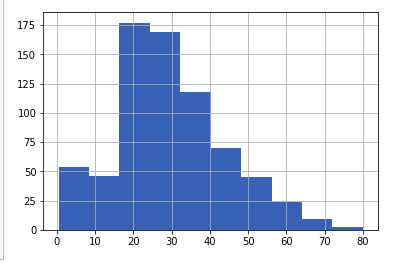

In [12]:
def cat_age(x):
    try:
        x = int(x)
        if x >= 0 and x<=18:
            return 1
        if x >18 and x<=32:
            return 2
        if x >32 and x<=40:
            return 3
        if x >40 and x<=50:
            return 4
        if x >50:
            return 5
        else:
            return 6
    except:
         return 0


In [59]:
df = df.withColumn("cat_age", lit(0))

cat_age_udf = udf(cat_age, IntegerType())

df = df.withColumn("cat_age", cat_age_udf(df['Age']))

In [60]:
df.select('cat_age').distinct().collect()

[Row(cat_age=1),
 Row(cat_age=3),
 Row(cat_age=5),
 Row(cat_age=4),
 Row(cat_age=2),
 Row(cat_age=0)]

2) Фамилия

In [61]:
def get_last_name(row):
    return row.split(",")[0]

In [62]:
my_udf = udf(get_last_name, StringType())
df = df.withColumn('LastName', my_udf(df['Name']))

In [63]:
stringIndexer = StringIndexer(inputCol="LastName", outputCol="FamilyIndex")

model = stringIndexer.fit(df)

indexed = model.transform(df)

encoder = OneHotEncoder(inputCol="FamilyIndex", outputCol="FamilyVec")
df = encoder.transform(indexed)

In [64]:
df[['LastName','FamilyIndex', 'FamilyVec']].show()

+-------------+-----------+-----------------+
|     LastName|FamilyIndex|        FamilyVec|
+-------------+-----------+-----------------+
|       Braund|       49.0| (686,[49],[1.0])|
|      Cumings|      424.0|(686,[424],[1.0])|
|    Heikkinen|      496.0|(686,[496],[1.0])|
|     Futrelle|       82.0| (686,[82],[1.0])|
|        Allen|       83.0| (686,[83],[1.0])|
|        Moran|       39.0| (686,[39],[1.0])|
|     McCarthy|      650.0|(686,[650],[1.0])|
|      Palsson|       15.0| (686,[15],[1.0])|
|      Johnson|        3.0|  (686,[3],[1.0])|
|       Nasser|      105.0|(686,[105],[1.0])|
|    Sandstrom|       68.0| (686,[68],[1.0])|
|      Bonnell|      161.0|(686,[161],[1.0])|
|  Saundercock|      643.0|(686,[643],[1.0])|
|    Andersson|        0.0|  (686,[0],[1.0])|
|      Vestrom|      208.0|(686,[208],[1.0])|
|      Hewlett|      567.0|(686,[567],[1.0])|
|         Rice|        7.0|  (686,[7],[1.0])|
|     Williams|       42.0| (686,[42],[1.0])|
|Vander Planke|       23.0| (686,[

3) наличие семьи больше или равно 2 чел.

In [65]:
def get_family(name, parch, sibsp):
    last_name = name.split(",")[0]
    if last_name:
        family_size = 1 + int(parch) + int(sibsp)
        if family_size >= 2:
            return 1
        else:
            return 2
    else:
        return 0


In [66]:
udf_get_family = udf(get_family, IntegerType())
df = df.withColumn('family', udf_get_family(df['Name'], df['Parch'], df['SibSp']))

In [67]:
df.select('family').distinct().collect()

[Row(family=1), Row(family=2)]

4) Количество родственников на борту

In [29]:
def get_rel(name, parch, sibsp):
    last_name = name.split(",")[0]
    if last_name:
        fs = 1 + int(parch) + int(sibsp)
        return fs
    else:
        return 0


In [68]:
udf_get_rel = udf(get_rel, IntegerType())
df = df.withColumn('relatives', udf_get_rel(df['Name'], df['Parch'], df['SibSp']))

5) Плыл ли пассажир сам

In [39]:
def alone(parch, sibsp):
    if int(parch) + int(sibsp) > 0:
        return 1
    else:
        return 0

In [69]:
udf_alone = udf(alone, IntegerType())
df = df.withColumn('alone', udf_alone(df['SibSp'], df['Parch'] ))

In [70]:
def transf(r):
    return LabeledPoint(
        int(r.Survived),
        [
            int(r.Pclass),
            
            r.Sex == 'male',
            
            float(r.Fare),
            
            int(r.cat_age),
            
            int(r.Parch),           
            
            int(r.family),
            
            int(r.relatives),
            
            int(r.alone),
            
        ] 
        + list(r.EmbarkedVec.toArray()) 
        + list(r.FamilyVec.toArray())  
    )

In [71]:
data = df.rdd.map(transf)

In [72]:
train, test = data.randomSplit([0.7, 0.3])

In [49]:
from pyspark.mllib.tree import RandomForest, RandomForestModel

In [73]:
rfc = RandomForest.trainClassifier(train, numClasses=2, categoricalFeaturesInfo={}, numTrees=100)

In [87]:
def f1(k, test):
    vals = test.map(lambda x: x.features)
    
    y_pred = k.predict(vals).map(lambda x: float(x))
    
    y = test.map(lambda x: x.label)
    
    comp = y_pred.zip(y)
    
    tp = comp.map(lambda x: 1 if x[0] == 1 and x[1] == 1 else 0).sum()
    fp = comp.map(lambda x: 1 if x[0] == 1 and x[1] == 0 else 0).sum()
    fn = comp.map(lambda x: 1 if x[0] == 0 and x[1] == 1 else 0).sum()
    
    try:
        precision = 1.0 * tp / (tp + fp)
        recall    = 1.0 * tp / (tp + fn)
        return 2.0 * precision * recall / (precision + recall)
    except:
        print 'divide by 0'


In [74]:
def acc(m, test):
    values = test.map(lambda x: x.features)
    yhat = rfc.predict(values)
    y = test.map(lambda x: x.label)
    comp = yhat.zip(y)
    errors = comp.map(lambda x: abs(x[0]-x[1]))
    return 1-errors.sum()/errors.count()

In [88]:
acc(rfc, test)

0.572463768115942

In [89]:
f1(rfc, test)

0.048387096774193554

In [79]:
import pyspark.mllib.regression as regr
rrs = regr.RidgeRegressionWithSGD.train(train)

In [80]:
acc(rrs, test)

0.572463768115942

In [90]:
f1(rrs, test)

divide by 0


In [81]:
from pyspark.mllib.classification import NaiveBayes
nbc = NaiveBayes.train(train)
acc(nbc, test)

0.572463768115942

In [91]:
f1(nbc, test)

0.5284974093264247

In [92]:
from pyspark.mllib.classification import SVMWithSGD
svmc = SVMWithSGD.train(train)
acc(svmc, test)

0.572463768115942

In [93]:
f1(svmc, test)

0.6200873362445415